In [16]:
import gc
from tabulate import tabulate
import time
import pandas as pd
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from tqdm import tqdm

import cv2
import os
import tensorflow as tf
import sklearn as sk

import warnings
warnings.filterwarnings('ignore')


#It is important to check the version of these libraries to make sure that implement the latest method.
print('Tensorflow version:', tf.__version__)
print('CV2 version:', cv2.__version__)

Tensorflow version: 2.8.0
CV2 version: 4.5.5


In [8]:
# install TF addons if needed
try:
    import tensorflow_addons as tfa  # main package
except ModuleNotFoundError:
    !pip install tensorflow-addons
    import tensorflow_addons as tfa
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

In [9]:
import tensorflow_datasets as tfds
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up
# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()
print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

TensorFlow: 2.8.0
TensorFlow Similarity 0.15.8


In [10]:
DATA_PATH = Path("tfsim_contrastive_model")
if not DATA_PATH.exists():
    DATA_PATH.mkdir(parents=True)

In [11]:
# Import data_labels_mainData.csv into a DataFrame
main_data = pd.read_csv('data_labels_mainData.csv')

# Import data_labels_extraData.csv into a DataFrame
extra_data = pd.read_csv('data_labels_extraData.csv')

In [12]:
from sklearn.model_selection import train_test_split

#splitting data into train and validation 

train_task, val_task = train_test_split(main_data[['ImageName','cellType']], 
                                              test_size=0.3, random_state=9)                                        


In [13]:
from PIL import Image
def GetImage(directory):
    images=[]
    for name in tqdm(directory, desc="Adding images"):
        image = cv2.imread("patch_images/"+name)
        image = Image.fromarray(image,'RGB')
        images.append(np.array(image))
    result = np.array(images)
    print("\ngetImage COMPLETED!")
    return result

#Create a function to generate sample to fix the Imblance of the dataset
from imblearn.over_sampling import RandomOverSampler
def GenerateSample(X,Y):
    ros = RandomOverSampler(random_state = 1)
    x, y = ros.fit_resample(X.values.reshape(-1,1), Y)
    x = x.flatten()
    return x,y

In [14]:
x_train = train_task['ImageName']
y_train = train_task['cellType']
print("Original Dataset:\n",y_train.value_counts())

#Generate sample
x_train, y_train = GenerateSample(x_train,y_train)
print("Sampled Dataset:\n",y_train.value_counts())
x_train = GetImage(x_train)

x_test = val_task['ImageName']
x_test = GetImage(x_test)

y_test = val_task['cellType']


Original Dataset:
 2    2897
1    1778
0    1302
3     950
Name: cellType, dtype: int64
Sampled Dataset:
 1    2897
2    2897
3    2897
0    2897
Name: cellType, dtype: int64


Adding images: 100%|██████████| 11588/11588 [00:03<00:00, 3303.83it/s]



getImage COMPLETED!


Adding images: 100%|██████████| 2969/2969 [00:00<00:00, 3050.52it/s]


getImage COMPLETED!


In [17]:
# Compute the indicies for query, index, val, and train splits
query_idxs, index_idxs, val_idxs, train_idxs = [], [], [], []
for cid in range(4):
    idxs = tf.random.shuffle(tf.where(y_train == cid))
    idxs = tf.reshape(idxs, (-1,))
    query_idxs.extend(idxs[:200])  # 200 query examples per class
    index_idxs.extend(idxs[200:400])  # 200 index examples per class
    val_idxs.extend(idxs[400:500])  # 100 validation examples per class
    train_idxs.extend(idxs[500:])  # The remaining are used for training

random.shuffle(query_idxs)
random.shuffle(index_idxs)
random.shuffle(val_idxs)
random.shuffle(train_idxs)

In [20]:
def create_split(idxs: list) -> tuple:
    x, y = [], []
    for idx in idxs:
        x.append(x_train[int(idx)])
        y.append(y_train[int(idx)])
    return tf.convert_to_tensor(np.array(x)), tf.convert_to_tensor(np.array(y))


x_query, y_query = create_split(query_idxs)
x_index, y_index = create_split(index_idxs)
x_val, y_val = create_split(val_idxs)
x_train, y_train = create_split(train_idxs)

In [21]:
print(
    tabulate(
        [
            ["train", x_train.shape, y_train.shape],
            ["val", x_val.shape, y_val.shape],
            ["query", x_query.shape, y_query.shape],
            ["index", x_index.shape, y_index.shape],
            ["test", x_test.shape, y_test.shape],
        ],
        headers=["Examples", "Labels"],
    )
)

       Examples           Labels
-----  -----------------  --------
train  (9588, 27, 27, 3)  (9588,)
val    (400, 27, 27, 3)   (400,)
query  (800, 27, 27, 3)   (800,)
index  (800, 27, 27, 3)   (800,)
test   (2969, 27, 27, 3)  (2969,)


In [22]:
ALGORITHM = "simsiam"  # @param ["barlow", "simsiam", "simclr"]


In [23]:
IMG_SIZE = 27

if ALGORITHM == "simsiam":
    BATCH_SIZE = 512
    PRE_TRAIN_EPOCHS = 800
    PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
    VAL_STEPS_PER_EPOCH = 20
    WEIGHT_DECAY = 5e-4
    INIT_LR = 3e-2 * int(BATCH_SIZE / 256)
    WARMUP_LR = 0.0
    WARMUP_STEPS = 0
    DIM = 2048  # The layer size for the projector and predictor models.
elif ALGORITHM == "barlow":
    BATCH_SIZE = 512
    PRE_TRAIN_EPOCHS = 800
    PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
    VAL_STEPS_PER_EPOCH = 20
    WEIGHT_DECAY = 5e-4
    INIT_LR = 1e-3  # Initial LR for the learning rate schedule.
    WARMUP_LR = 0.0
    WARMUP_STEPS = 1000
    DIM = 2048  # The layer size for the projector and predictor models.
elif ALGORITHM == "simclr":
    BATCH_SIZE = 512
    PRE_TRAIN_EPOCHS = 800
    PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
    VAL_STEPS_PER_EPOCH = 20
    WEIGHT_DECAY = 5e-4
    INIT_LR = 1e-3  # Initial LR for the learning rate schedule, see section B.1 in the paper.
    TEMPERATURE = 0.5  # Tuned for CIFAR10, see section B.9 in the paper.
    DIM = 2048  # The layer size for the projector and predictor models.

In [25]:
def img_scaling(img):
    return tf.keras.applications.imagenet_utils.preprocess_input(
        img, 
        data_format=None, 
        mode='torch')

@tf.function
def simsiam_augmenter(img, blur=True, area_range=(0.2, 1.0)):
    """SimSiam augmenter.

    The SimSiam augmentations are based on the SimCLR augmentations, but have
    some important differences.
    * The crop area lower bound is 20% instead of 8%.
    * The color jitter and grayscale are applied separately instead of together.
    * The color jitter ranges are much smaller.
    * Blur is not applied for the cifar10 dataset.

    args:
        img: Single image tensor of shape (H, W, C)
        blur: If true, apply blur. Should be disabled for cifar10.
        area_range: The upper and lower bound of the random crop percentage.

    returns:
        A single image tensor of shape (H, W, C) with values between -1.0 and 1.0.
    """
    # random resize and crop. Increase the size before we crop.
    img = tfsim.augmenters.simclr.crop_and_resize(
        img, IMG_SIZE, IMG_SIZE, area_range=area_range
    )
    
    # The following transforms expect the data to be [0, 1]
    img /= 255.
                       
    # random color jitter
    def _jitter_transform(x):
        return tfsim.augmenters.simclr.color_jitter_rand(
            x,
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.1),
            "simclrv2",
        )

    img = tfsim.augmenters.simclr.random_apply(_jitter_transform, p=0.8, x=img)

    # random grayscale
    def _grascayle_transform(x):
        return tfsim.augmenters.simclr.to_grayscale(x)

    img = tfsim.augmenters.simclr.random_apply(_grascayle_transform, p=0.2, x=img)

    # optional random gaussian blur
    if blur:
        img = tfsim.augmenters.simclr.random_blur(img, p=0.5)

    # random horizontal flip
    img = tf.image.random_flip_left_right(img)
    
    # scale the data back to [0, 255]
    img = img * 255.
    img = tf.clip_by_value(img, 0., 255.)

    return img


@tf.function()
def process(img):
    view1 = simsiam_augmenter(img, blur=False)
    view1 = img_scaling(view1)
    view2 = simsiam_augmenter(img, blur=False)
    view2 = img_scaling(view2)
    return (view1, view2)


train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.repeat()
val_ds = val_ds.shuffle(1024)
val_ds = val_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

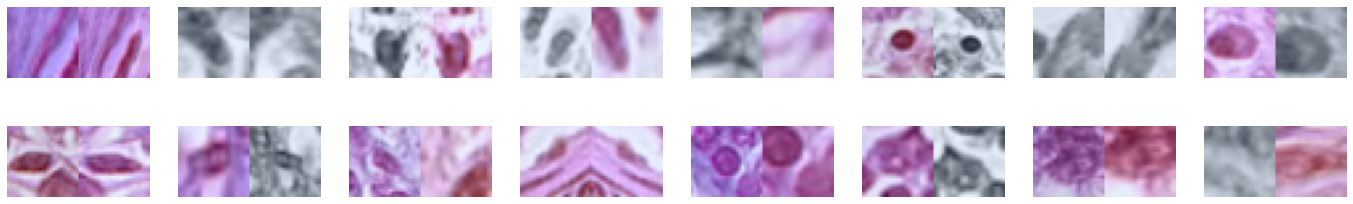

In [26]:
display_imgs = next(train_ds.as_numpy_iterator())
max_pixel = np.max([display_imgs[0].max(), display_imgs[1].max()])
min_pixel = np.min([display_imgs[0].min(), display_imgs[1].min()])

tfsim.visualization.visualize_views(
    views=display_imgs,
    num_imgs=16,
    views_per_col=8,
    max_pixel_value=max_pixel,
    min_pixel_value=min_pixel,
)

In [28]:
def get_backbone(img_size, activation="relu", preproc_mode="torch"):
    input_shape = (img_size, img_size, 3)

    backbone = tfsim.architectures.ResNet18Sim(
        input_shape,
        include_top=False,  # Take the pooling layer as the output.
        pooling="avg",
    )
    return backbone


backbone = get_backbone(IMG_SIZE)
backbone.summary()

Model: "resnet18sim"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 27, 27, 3)]       0         
                                                                 
 resnet18 (Functional)       (None, 4, 4, 512)         11182784  
                                                                 
 avg_pool (GlobalAveragePool  (None, 512)              0         
 ing2D)                                                          
                                                                 
Total params: 11,182,784
Trainable params: 11,173,056
Non-trainable params: 9,728
_________________________________________________________________


In [29]:
def get_projector(input_dim, dim, activation="relu", num_layers: int = 3):
    inputs = tf.keras.layers.Input((input_dim,), name="projector_input")
    x = inputs

    for i in range(num_layers - 1):
        x = tf.keras.layers.Dense(
            dim,
            use_bias=False,
            kernel_initializer=tf.keras.initializers.LecunUniform(),
            name=f"projector_layer_{i}",
        )(x)
        x = tf.keras.layers.BatchNormalization(epsilon=1.001e-5, name=f"batch_normalization_{i}")(x)
        x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_{i}")(x)
    x = tf.keras.layers.Dense(
        dim,
        use_bias=False,
        kernel_initializer=tf.keras.initializers.LecunUniform(),
        name="projector_output",
    )(x)
    x = tf.keras.layers.BatchNormalization(
        epsilon=1.001e-5,
        center=False,  # Page:5, Paragraph:2 of SimSiam paper
        scale=False,  # Page:5, Paragraph:2 of SimSiam paper
        name=f"batch_normalization_ouput",
    )(x)
    # Metric Logging layer. Monitors the std of the layer activations.
    # Degnerate solutions colapse to 0 while valid solutions will move
    # towards something like 0.0220. The actual number will depend on the layer size.
    o = tfsim.layers.ActivationStdLoggingLayer(name="proj_std")(x)
    projector = tf.keras.Model(inputs, o, name="projector")
    return projector


projector = get_projector(input_dim=backbone.output.shape[-1], dim=DIM, num_layers=2)
projector.summary()

Model: "projector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 projector_input (InputLayer  [(None, 512)]            0         
 )                                                               
                                                                 
 projector_layer_0 (Dense)   (None, 2048)              1048576   
                                                                 
 batch_normalization_0 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 relu_activation_0 (Activati  (None, 2048)             0         
 on)                                                             
                                                                 
 projector_output (Dense)    (None, 2048)              4194304   
                                                         

In [30]:
def get_predictor(input_dim, hidden_dim=512, activation="relu"):
    inputs = tf.keras.layers.Input(shape=(input_dim,), name="predictor_input")
    x = inputs

    x = tf.keras.layers.Dense(
        hidden_dim,
        use_bias=False,
        kernel_initializer=tf.keras.initializers.LecunUniform(),
        name="predictor_layer_0",
    )(x)
    x = tf.keras.layers.BatchNormalization(epsilon=1.001e-5, name="batch_normalization_0")(x)
    x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_0")(x)

    x = tf.keras.layers.Dense(
        input_dim,
        kernel_initializer=tf.keras.initializers.LecunUniform(),
        name="predictor_output",
    )(x)
    # Metric Logging layer. Monitors the std of the layer activations.
    # Degnerate solutions colapse to 0 while valid solutions will move
    # towards something like 0.0220. The actual number will depend on the layer size.
    o = tfsim.layers.ActivationStdLoggingLayer(name="pred_std")(x)
    predictor = tf.keras.Model(inputs, o, name="predictor")
    return predictor


predictor = get_predictor(input_dim=DIM, hidden_dim=512)
predictor.summary()

Model: "predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 predictor_input (InputLayer  [(None, 2048)]           0         
 )                                                               
                                                                 
 predictor_layer_0 (Dense)   (None, 512)               1048576   
                                                                 
 batch_normalization_0 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 relu_activation_0 (Activati  (None, 512)              0         
 on)                                                             
                                                                 
 predictor_output (Dense)    (None, 2048)              1050624   
                                                         

In [31]:
if ALGORITHM == "simsiam":
    loss = tfsim.losses.SimSiamLoss(projection_type="cosine_distance", name=ALGORITHM)

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        predictor=predictor,  # NOTE: simiam requires predictor model.
        algorithm=ALGORITHM,
        name=ALGORITHM,
    )
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=INIT_LR,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
    )
    wd_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=WEIGHT_DECAY,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
    )
    optimizer = tfa.optimizers.SGDW(learning_rate=lr_decayed_fn, weight_decay=wd_decayed_fn, momentum=0.9)
elif ALGORITHM == "barlow":
    loss = tfsim.losses.Barlow(name=ALGORITHM)

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        algorithm="barlow",
    )
    optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR)
elif ALGORITHM == "simclr":
    loss = tfsim.losses.SimCLRLoss(name=ALGORITHM, temperature=TEMPERATURE)

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        algorithm=ALGORITHM,
    )
    optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR)
else:
    raise ValueError(f"{ALGORITHM} is not supported.")

In [32]:
contrastive_model.compile(
    optimizer=optimizer,
    loss=loss,
)

In [33]:
log_dir = DATA_PATH / "models" / "logs" / f"{loss.name}_{time.time()}"
chkpt_dir = DATA_PATH / "models" / "checkpoints" / f"{loss.name}_{time.time()}"


evb = tfsim.callbacks.EvalCallback(
    img_scaling(tf.cast(x_query, tf.float32)),
    y_query,
    img_scaling(tf.cast(x_index, tf.float32)),
    y_index,
    metrics=["binary_accuracy"],
    k=1,
    tb_logdir=log_dir,
)
tbc = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=100,
)
mcp = tf.keras.callbacks.ModelCheckpoint(
    filepath=chkpt_dir,
    monitor="loss",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
)

TensorBoard logging enable in tfsim_contrastive_model\models\logs\simsiam_1652352409.2558203\index


In [ ]:
history = contrastive_model.fit(
    train_ds,
    epochs=PRE_TRAIN_EPOCHS,
    steps_per_epoch=PRE_TRAIN_STEPS_PER_EPOCH,
    validation_data=val_ds,
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[evb, tbc, mcp],
)